# Physics analysis with uproot (and some coffea)


## What we are trying to do

This session will be rather similar to the tutorial notebook that's already available, but I want to focus a bit more on how to use our physics knowledge to implement useful variables, and verify that we're actually calculating something useful.

You can run this notebook in jupyter yourself, or also use ipython instead. If you use a ssh session with X11 forwarding, you'll also see the plots.


## What you should take home from this session

- Explore data in a jupyter notebook (or ipython session).
- Filter data, calculate variables
- Verify your selections and variables qualitatively and quantitatively

## The physics case

Consider that we want to find top quark pair production with an associated W boson (ttW) in events with 3 leptons. In this case, all the involved W bosons will decay leptonically. If one swaps the associated W boson with a Z boson (ttZ) a similar final state is also present.

The production cross sections of the two processes are of the same order (0.6pb vs 1.0pb), however, because of the different branching fractions the ttZ process will usually be dominant in the 3l final state.

The leptonic Z boson decay from ttZ gives us a handle to distinguish the two processes. If we succeed in identifying $Z \rightarrow \ell \ell$ events, we can reject those events and end up with a event sample that's enriched in ttW.

![](https://cds.cern.ch/record/2264544/files/Figure_001-a.pdf)

![](http://cds.cern.ch/record/2264544/files/Figure_001-b.pdf)


- Find lepton pairs with the same flavor and opposite charge
- Calculate their invariant mass
- Find lepton pairs that have an invariant mass that's compatible with the Z boson mass, e.g. |m(ll)-m(Z)|<10 GeV
- Last but not least, make sure the variable we calculate makes sense and the implementation is bug free




## Load modules and files



In [1]:
import uproot4
import numpy as np
from uproot_methods import TLorentzVectorArray

from coffea.processor import LazyDataFrame
from coffea.analysis_objects import JaggedCandidateArray

To start some expolartion we can just use a single root file of a sample that represents a process we're interested in. Because we want to reconstruct leptonic Z decays and eventually want to reject ttZ events we load a file from a ttZ sample to start this session.

In [2]:
fn_ttZ = '/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/0p1p11/TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8_RunIIAutumn18NanoAODv6-Nano25Oct2019_102X_upgrade2018_realistic_v20_ext1-v1/nanoSkim_1.root'
fn_ttW = '/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/0p1p11/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_RunIIAutumn18NanoAODv6-Nano25Oct2019_102X_upgrade2018_realistic_v20_ext1-v1/nanoSkim_1.root'

file = uproot4.open(fn_ttZ)

tree = file['Events']

df = LazyDataFrame(tree, flatten=False)

In [3]:
df['MET_pt']

array([281.09677 , 220.44043 , 157.86841 , ...,  58.63539 ,  88.826164,
       153.44633 ], dtype=float32)

## Get physics objects

Tau leptons are very special (and dificult). Therefore we'll focus on electrons and muons in this analysis. We can get muon and electron candidate arrays using `JaggedCandidateArray.candidatesfromcounts`.


In [3]:
muon = JaggedCandidateArray.candidatesfromcounts(
    # The first part is essential: number of muons, and kinematic properties
    df['nMuon'],
    pt = df['Muon_pt'].content,
    eta = df['Muon_eta'].content,
    phi = df['Muon_phi'].content,
    mass = df['Muon_mass'].content,
    # all below is optional
    mediumId = df['Muon_mediumId'].content,
    miniPFRelIso_all = df['Muon_miniPFRelIso_all'].content,
    charge = df['Muon_charge'].content,
)

In [4]:
electron = JaggedCandidateArray.candidatesfromcounts(
    # The first part is essential: number of electrons, and kinematic properties
    df['nElectron'],
    pt=df['Electron_pt'].content,
    eta=df['Electron_eta'].content,
    phi=df['Electron_phi'].content,
    mass=df['Electron_mass'].content,
    # all below is optional
    cutBased=df['Electron_cutBased'].content,
    miniPFRelIso_all=df['Electron_miniPFRelIso_all'].content,
    charge=df['Electron_charge'].content,
)

We can look at the properties of the muons, e.g. the transverse momentum, eta, medium ID etc.

We can already see the structure of the muons: they are of a JaggedArray type, which means muons from every event are contained in a sub-array. The structure is jagged because you can have any number of muons. If there's no muon in the event, the array is empty.   


In [9]:
muon.mediumId

<JaggedArray [[True] [True] [] ... [True True] [True True True False False] []] at 0x7faec0429160>

This means that the length of the electron and muon array should be the same - the number of events is the same.

In [10]:
print ("Is the number of events the same?", len(muon) == len(electron))
print ("Is the number of electrons and muons the same?", muon.counts.sum() == electron.counts.sum())

Is the number of events the same? True
Is the number of electrons and muons the same? False


The number of muons and electrons per event is of course not the same, and we can look at the number of muons or electrons with

In [13]:
muon.counts

array([1, 1, 0, ..., 2, 5, 0])

Noticed the change of format from JaggedArray to array? Why?

Because some of our electrons and muons are wrongly reconstructed, we impose some requirements on them:

In [14]:
muon = muon[
    (muon.pt>10) & 
    (abs(muon.eta)<2.4) & 
    (muon.mediumId) & 
    (muon.miniPFRelIso_all<0.2) 
]

electron = electron[
    (electron.pt>10) & 
    (abs(electron.eta)<2.4) & 
    (electron.cutBased>=3) & 
    (electron.miniPFRelIso_all<0.1) 
]

Let's check if those requirements actually worked. This is already one of the most important lessons and take aways from this tutorial: Always check if your code makes sense!

In [15]:
muon.mediumId

<JaggedArray [[True] [True] [] ... [True True] [True True True] []] at 0x7faebfa41d60>

For today, let's focus on events with three leptons - either electrons or muons. Because in real data we'd rely on a trigger selecting those events we need to make sure that our selected leptons also pass any potential trigger threshold. Lepton triggers usually have a minimum requirement on the transverse momentum, e.g. 30 GeV. Only one of the electrons or muons has to pass that threshold, so we use the .any() function.

In [16]:
baseline = ((electron.counts+muon.counts)==3) & ((electron.pt>30).any() | (muon.pt>30).any())

Does this .any() function actually do what we think it does? Let's check!

In [17]:
electron.pt

<JaggedArray [[219.92007 98.10683] [32.235016] [] ... [] [] [30.372639]] at 0x7faebfc428b0>

In [20]:
(electron.pt>30).any()

array([ True,  True, False, ..., False, False,  True])

Looks pretty good! We do have at least one electron with pT>30 GeV in the first two events, but none in the third.


A common mistake would be to just ask for `electron.pt>30` without proper counting. E.g. this would be an alternative approach:

In [22]:
(electron.pt>30).counts>0

array([ True,  True, False, ..., False, False,  True])

NB: Always check the behaviour of a function. I've also seen sth like

In [23]:
electron[electron>1] # don't try this at home!

<JaggedCandidateArray [[] [] [] ... [] [] []] at 0x7faec0402c70>

This clearly does not select the number of electrons, as one might have thought. Let's apply the baseline selection we defined above, and just work with events that pass our requirements from here on.

In [24]:
muon = muon[baseline]
electron = electron[baseline]

## Constructing dileptons

`JaggedCandidateArray` has some nice functionality to get pairs (or triplets etc) of different kinds of objects. We can use `.choose(2)` to get any combination of two muons or electrons.

If one wants to get combinations of e.g. electrons and muons one can use the `.cross()` method like `electron.cross(muon)`.

Because Z bosons decay into leptons of same flavor and opposite signed charge (OS) we only select those dimuons of dielectrons with a charge product that is smaller than 0.


In [25]:
dimuon = muon.choose(2)
OS_dimuon = dimuon[(dimuon.i0.charge*dimuon.i1.charge < 0)]

dielectron = electron.choose(2)
OS_dielectron = dielectron[(dielectron.i0.charge*dielectron.i1.charge < 0)]

We can calculate an invariant mass of these dileptons. Notice the empty arrays for events where no opposite sign dimuon is found in the event!

In [26]:
OS_dimuon.mass

<JaggedArray [[] [] [89.871895] ... [] [102.24671 134.28061] []] at 0x7faec0402a90>

## Reconstructing Z boson candidates

The invariant mass resultion is finite, therefore we allow the dimuon or dielectron mass to be within 10 GeV of the Z boson mass to find a good $Z\rightarrow \mu \mu$ candidate.

Then, we calculate how many of our ttZ events with 3 leptons also have a good Z boson candidate per our definitions (or events that are so-called on-Z).

In [32]:
nEvents_all = len(muon)

nEvents_onZmumu = len(muon[(abs(OS_dimuon.mass-91.2)<10).any()])
nEvents_onZee = len(electron[(abs(OS_dielectron.mass-91.2)<10).any()])

(nEvents_onZmumu+nEvents_onZee)/nEvents_all


0.7313055823586895

Inversely, we can also get the number of events that have no good Z boson candidate ("off-Z"). The total of on-Z and off-Z events should of course be 1, so that's a good way to check that our selections make sense.

In [33]:
nEvents_offZ = len(muon[(abs(OS_dimuon.mass-91.2)>10).all() & (abs(OS_dielectron.mass-91.2)>10).all()])

(nEvents_onZmumu + nEvents_onZee + nEvents_offZ)/nEvents_all

1.0

Why do we not have double counting of events here? Can you think of a case where double counting of events with a $Z \rightarrow \mu \mu$ and $Z \rightarrow e e$ candidate might become an issue?

Noticed the `.all()` function here? In contrast to `.any()` which requires at least one of the dileptons to be close to the Z mass, our `.all()` requirement forces all dimuon or dielectron candidates in an event to be at least 10 GeV away from the Z boson mass. 

Below we ask for the "best" Z candidate: if we have 3 muons, we will find two OS dimuons, but one of the pairs will have a mass that's closer to the Z boson. We can find the `OS_dimuon` that has the closest mass with the `argmin()` method.

In [34]:
OS_dimuon_bestZmumu = OS_dimuon[abs(OS_dimuon.mass-91.2).argmin()]
OS_dielectron_bestZee = OS_dielectron[abs(OS_dielectron.mass-91.2).argmin()]

`argmin()` returns the index to the dimuon pair that is our best Z candidate. As an example, we can look at events with 3 muons:

In [35]:
OS_dimuon[muon.counts==3].mass

<JaggedArray [[19.85868 92.83723] [112.70271 89.79507] [865.53973 81.082664] ... [92.34522 96.08944] [92.30167 39.55939] [102.24671 134.28061]] at 0x7faebfa67fd0>

In [36]:
abs(OS_dimuon[muon.counts==3].mass-91.2).argmin()

<JaggedArray [[1] [1] [1] ... [0] [0] [0]] at 0x7faebfa67eb0>

`argmin` and `argmax` are very useful methods, e.g. if you want to get the transverse momentum of the muon with highest eta: `muon[abs(muon.eta).argmax()].pt`.

We can use matplotlib to make histograms of our variables. The `.flatten()` method is needed in order to get a flat array (in contrast to a jagged one).

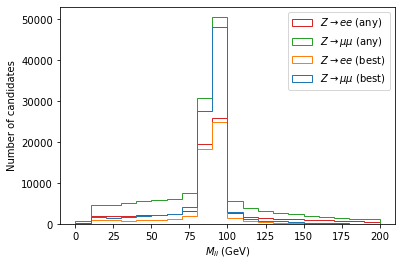

In [37]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


figure=plt.figure(1)
plt.hist(
    [OS_dimuon_bestZmumu.mass.flatten(), OS_dielectron_bestZee.mass.flatten(), OS_dimuon.mass.flatten(), OS_dielectron.mass.flatten()], 
    bins=20, 
    range=[0, 200], 
    label=[r'$Z \rightarrow \mu \mu$ (best)', r'$Z \rightarrow e e$ (best)', r'$Z \rightarrow \mu \mu$ (any)', r'$Z \rightarrow e e$ (any)'], 
    histtype='step'
)

plt.xlabel(r'$M_{ll}$ (GeV)')
plt.ylabel('Number of candidates')
plt.legend()

plt.show()


So, how could we best veto these events? The easiest way is to just force all dilepton candidates to have an invariant mass away from the Z boson mass, like we have done earlier

In [38]:
(abs(OS_dimuon.mass-91.2)>10).all() & (abs(OS_dielectron.mass-91.2)>10).all()

array([False, False, False, ..., False,  True, False])

In [62]:
abs(OS_dimuon[muon.counts==3].mass-91.2)>10

<JaggedArray [[True False] [True False] [True True] ... [False False] [False True] [True True]] at 0x7fb03fd2ebe0>

In [64]:
(abs(OS_dimuon[muon.counts==3].mass-91.2)>10).all()

array([False, False,  True, ..., False, False,  True])

Let's quickly look at the best Z candidates again. We now have seperate arrays for muons and electrons, but we might want to have them combined, too.

In [39]:
OS_dimuon_bestZmumu.mass

<JaggedArray [[] [] [89.871895] ... [] [102.24671] []] at 0x7fb05835cac0>

In [40]:
OS_dielectron_bestZee.mass

<JaggedArray [[89.51785] [92.096634] [] ... [92.81694] [] [84.79572]] at 0x7faf308a7220>

So, how can we combine two JaggedArrays? It's not exactly straight forward, but it can be done.

In [41]:
from Tools.helpers import mergeArray

OS_dilepton_mass = mergeArray(OS_dimuon_bestZmumu.mass, OS_dielectron_bestZee.mass)

In [42]:
OS_dilepton_mass

<JaggedArray [[89.51785] [92.096634] [89.871895] ... [92.81694] [102.24671] [84.79572]] at 0x7faec0429520>

What does mergeArry do?
```
def mergeArray(a1, a2):
    '''
    Merge two arrays into one, e.g. electrons and muons
    '''
    import awkward
    a1_tags = awkward.JaggedArray(a1.starts, a1.stops, np.full(len(a1.content), 0, dtype=np.int64))
    a1_index = awkward.JaggedArray(a1.starts, a1.stops, np.arange(len(a1.content), dtype=np.int64))
    a2_tags = awkward.JaggedArray(a2.starts, a2.stops, np.full(len(a2.content), 1, dtype=np.int64))
    a2_index = awkward.JaggedArray(a2.starts, a2.stops, np.arange(len(a2.content), dtype=np.int64))
    tags = awkward.JaggedArray.concatenate([a1_tags, a2_tags], axis=1)
    index = awkward.JaggedArray.concatenate([a1_index, a2_index], axis=1)
    return awkward.JaggedArray(tags.starts, tags.stops, awkward.UnionArray(tags.content, index.content, [a1.content, a2.content]))
```


Since we have trilepton events and we already chose the *best* Z boson candidate our new JaggedArray, `OS_dilepton_mass`, should not have an event with more than one entry. As a sanity check we can still do

In [43]:
(OS_dilepton_mass.counts>1).any()

False

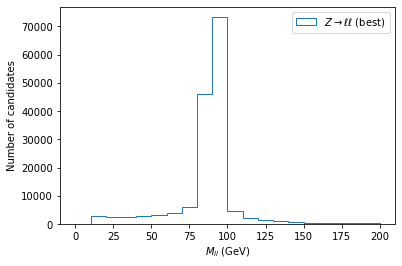

In [44]:
figure=plt.figure(1)
plt.hist(
    [OS_dilepton_mass.flatten()], 
    bins=20, 
    range=[0, 200], 
    label=[r'$Z \rightarrow \ell \ell$ (best)'], 
    histtype='step'
)

plt.xlabel(r'$M_{ll}$ (GeV)')
plt.ylabel('Number of candidates')
plt.legend()

plt.show()

We can also use some coffea tools to make some histograms. The syntax isn't very different, but since we'll use coffea later on to process larger amounts of data, it makes sense to familiarize ourselves with them.

In [45]:
from coffea import hist

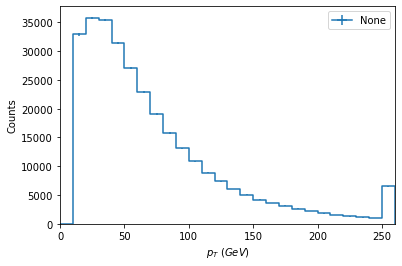

In [46]:
muon_pt = hist.Hist("Counts", hist.Bin("pt", r"$p_{T} \ (GeV)$", 25, 0, 250))
muon_pt.fill( pt = muon.pt.flatten() )
ax = hist.plot1d(muon_pt, overflow='over')

We fill the histogram with `muon.pt.flatten()`. 

## Coffea processor - larger scale data processing

Coffea processors are nice to process larger amounts of data (or even more than just a single file). Once you have an idea of what variables you want to calculate and made sure they work as intended, you can put everything together in a processor.

The processor splits up the events into chunks and then either runs sequentially or in parallel on your local CPU or on a cluster. The results (which usually are just plain numbers or histograms) of the different chunks are accumulated and definide at initialization.


In [47]:
from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC

from Tools.helpers import loadConfig, getCutFlowTable, mergeArray
from Tools.objects import Collections
from Tools.cutflow import Cutflow

import copy

class exampleProcessor(processor.ProcessorABC):
    """Dummy processor used to demonstrate the processor principle"""
    def __init__(self):

        # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset",   "Primary dataset")
        pt_axis             = hist.Bin("pt",        r"$p_{T}$ (GeV)", 1000, 0, 1000)
        mass_axis           = hist.Bin("mass",      r"M (GeV)", 1000, 0, 2000)
        multiplicity_axis   = hist.Bin("multiplicity",         r"N", 20, -0.5, 19.5)

        self._accumulator = processor.dict_accumulator({
            "dimuon_mass" :     hist.Hist("Counts", dataset_axis, mass_axis),
            "dimuon_mass_offZ" : hist.Hist("Counts", dataset_axis, mass_axis),
            "diele_mass" :      hist.Hist("Counts", dataset_axis, mass_axis),
            "dilep_mass" :      hist.Hist("Counts", dataset_axis, mass_axis),
            
            "MET_pt" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "MET_pt_onZ" :      hist.Hist("Counts", dataset_axis, pt_axis),
            "MET_pt_offZ" :     hist.Hist("Counts", dataset_axis, pt_axis),
            
            "N_ele" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_mu" :            hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_jet" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'TTW':              processor.defaultdict_accumulator(int),
            'TTZ':              processor.defaultdict_accumulator(int),
            'totalEvents':      processor.defaultdict_accumulator(int),
        })
        
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        dataset = df["dataset"]
        cfg = loadConfig()

        # load all the default candidates (jets, leptons, ...)
        
        ## Jets
        jet = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt = df['Jet_pt'].content,
            eta = df['Jet_eta'].content,
            phi = df['Jet_phi'].content,
            mass = df['Jet_mass'].content,
            jetId = df['Jet_jetId'].content,
            puId = df['Jet_puId'].content,
            btagDeepB = df['Jet_btagDeepB'].content,
            
        )
        jet       = jet[(jet.pt>30) & (abs(jet.eta)<2.4) & (jet.jetId>0)]
        
        ## Muons.
        muon = JaggedCandidateArray.candidatesfromcounts(
            # The first part is essential: number of muons, and kinematic properties
            df['nMuon'],
            pt = df['Muon_pt'].content,
            eta = df['Muon_eta'].content,
            phi = df['Muon_phi'].content,
            mass = df['Muon_mass'].content,
            # all below is optional
            mediumId = df['Muon_mediumId'].content,
            miniPFRelIso_all = df['Muon_miniPFRelIso_all'].content,
            charge = df['Muon_charge'].content,
        )
        
        ## Electrons.
        electron = JaggedCandidateArray.candidatesfromcounts(
            # The first part is essential: number of electrons, and kinematic properties
            df['nElectron'],
            pt=df['Electron_pt'].content,
            eta=df['Electron_eta'].content,
            phi=df['Electron_phi'].content,
            mass=df['Electron_mass'].content,
            # all below is optional
            cutBased=df['Electron_cutBased'].content,
            miniPFRelIso_all=df['Electron_miniPFRelIso_all'].content,
            charge=df['Electron_charge'].content,
        )
        
        ## Selections
        muon = muon[
            (muon.pt>10) & 
            (abs(muon.eta)<2.4) & 
            (muon.mediumId) & 
            (muon.miniPFRelIso_all<0.2) 
        ]

        electron = electron[
            (electron.pt>10) & 
            (abs(electron.eta)<2.4) & 
            (electron.cutBased>=3) & 
            (electron.miniPFRelIso_all<0.1) 
        ]   

        ## MET
        met_pt  = df["MET_pt"]
        met_phi = df["MET_phi"]
        
        dimuon = muon.choose(2)
        OS_dimuon = dimuon[(dimuon.i0.charge*dimuon.i1.charge < 0)]

        dielectron = electron.choose(2)
        OS_dielectron = dielectron[(dielectron.i0.charge*dielectron.i1.charge < 0)]

        OS_dimuon_bestZmumu = OS_dimuon[abs(OS_dimuon.mass-91.2).argmin()]
        OS_dielectron_bestZee = OS_dielectron[abs(OS_dielectron.mass-91.2).argmin()]
        
        OS_dilepton_bestZll_mass = mergeArray(OS_dimuon_bestZmumu.mass, OS_dielectron_bestZee.mass)

        baseline = ((electron.counts+muon.counts)==3) & ((electron.pt>30).any() | (muon.pt>30).any())
        offZ_selection = (abs(OS_dimuon.mass-91.2)>15).all() & (abs(OS_dielectron.mass-91.2)>15).all()
        onZ_selection = ((abs(OS_dimuon.mass-91.2)<15).any() | (abs(OS_dielectron.mass-91.2)<15).any())
        
        
        output['totalEvents']['all'] += len(df['weight'])
        
        
        
        ## And fill the histograms
        
        # just the some multiplicities
        output['N_ele'].fill(dataset=dataset, multiplicity=electron[baseline].counts, weight=df['weight'][baseline]*cfg['lumi'])
        output['N_mu'].fill(dataset=dataset, multiplicity=muon[baseline].counts, weight=df['weight'][baseline]*cfg['lumi'])
        output['N_jet'].fill(dataset=dataset, multiplicity=jet[baseline].counts, weight=df['weight'][baseline]*cfg['lumi'])
                
        output['MET_pt'].fill(
            dataset=dataset,
            pt=met_pt[baseline].flatten(),
            weight=df['weight'][baseline]*cfg['lumi']
        )
        
        output['MET_pt_offZ'].fill(
            dataset=dataset,
            pt=met_pt[baseline & offZ_selection].flatten(),
            weight=df['weight'][baseline & offZ_selection]*cfg['lumi']
        )
        
        output['MET_pt_onZ'].fill(
            dataset=dataset,
            pt=met_pt[baseline & onZ_selection].flatten(),
            weight=df['weight'][baseline & onZ_selection]*cfg['lumi']
        )
        
        output['dimuon_mass'].fill(
            dataset=dataset,
            mass = OS_dimuon_bestZmumu[baseline].mass.flatten(),
            weight=df['weight'][baseline & (OS_dimuon_bestZmumu.counts>0)]*cfg['lumi']
        )
        
        output['dimuon_mass_offZ'].fill(
            dataset=dataset,
            mass = OS_dimuon_bestZmumu[baseline & offZ_selection ].mass.flatten(),
            weight=df['weight'][baseline & (OS_dimuon_bestZmumu.counts>0) & offZ_selection]*cfg['lumi']
        )
        
        output['diele_mass'].fill(
            dataset=dataset,
            mass = OS_dielectron_bestZee[baseline].mass.flatten(),
            weight=df['weight'][baseline & (OS_dielectron_bestZee.counts>0)]*cfg['lumi']
        )
        
        output['dilep_mass'].fill(
            dataset=dataset,
            # usage of np.array() is pretty awkward, but UnionArray doesn't work with the histograms (yet)
            mass = np.array(OS_dilepton_bestZll_mass[baseline & (OS_dilepton_bestZll_mass.counts>0)].flatten()),
            weight=df['weight'][baseline & (OS_dilepton_bestZll_mass.counts>0)]*cfg['lumi']
        )
        
        return output

    def postprocess(self, accumulator):
        return accumulator

The main part of the above processor code is pretty similar to what we've done before. We do fill histograms in the end, and we have to be careful that the length of the arrays for the variable of interest and the weight are aligned.


In [48]:
import glob

# Run the processor
fileset = fileset = {
    'TTZ': glob.glob('/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/0p1p11/TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8_RunIIAutumn18NanoAODv6-Nano25Oct2019_102X_upgrade2018_realistic_v20_ext1-v1/*.root'),
    'TTW': glob.glob('/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/0p1p11/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_RunIIAutumn18NanoAODv6-Nano25Oct2019_102X_upgrade2018_realistic_v20_ext1-v1/*.root'),
}
workers = 12
output = processor.run_uproot_job(fileset,
                                      treename='Events',
                                      processor_instance=exampleProcessor(),
                                      executor=processor.futures_executor,
                                      executor_args={'workers': workers, 'function_args': {'flatten': False}},
                                      chunksize=500000,
                                     )

In [49]:
output

{'dimuon_mass': <Hist (dataset,mass) instance at 0x7faf2e1a2a30>,
 'dimuon_mass_offZ': <Hist (dataset,mass) instance at 0x7faf2c580280>,
 'diele_mass': <Hist (dataset,mass) instance at 0x7faf2c580a00>,
 'dilep_mass': <Hist (dataset,mass) instance at 0x7faf2c580ca0>,
 'MET_pt': <Hist (dataset,pt) instance at 0x7faf2c580340>,
 'MET_pt_onZ': <Hist (dataset,pt) instance at 0x7faf2c580c10>,
 'MET_pt_offZ': <Hist (dataset,pt) instance at 0x7faf2c580130>,
 'N_ele': <Hist (dataset,multiplicity) instance at 0x7faf2c53aaf0>,
 'N_mu': <Hist (dataset,multiplicity) instance at 0x7faf2c53ac40>,
 'N_jet': <Hist (dataset,multiplicity) instance at 0x7faf2c53a970>,
 'TTW': defaultdict_accumulator(int, {}),
 'TTZ': defaultdict_accumulator(int, {}),
 'totalEvents': defaultdict_accumulator(int, {'all': 9245534})}

The histogram output looks as follows. We chose to have a large number of bins when running the processor, this way we are more flexible in the choice of the final binning later.

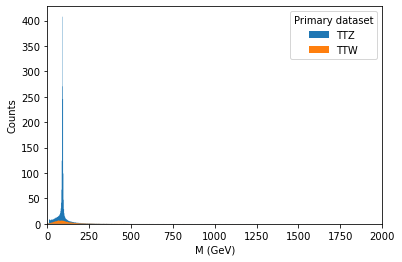

In [50]:
histogram = output['dilep_mass']
ax = hist.plot1d(histogram,overlay="dataset", stack=True)

Let's rebin to a more sensible range.

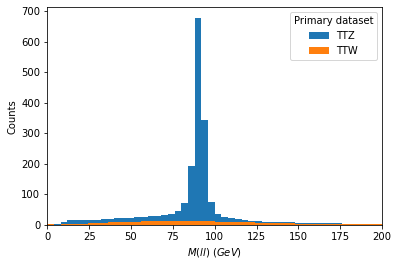

In [51]:
histogram = output['dilep_mass'].copy()
histogram = histogram.rebin('mass', hist.Bin('mass', r'$M(ll) \ (GeV)$', 50, 0, 200))

ax = hist.plot1d(histogram,overlay="dataset", stack=True)

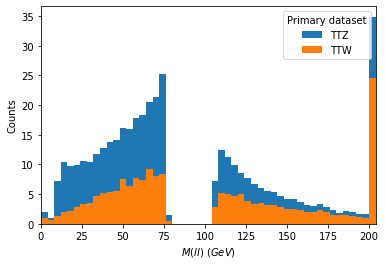

In [52]:
histogram = output['dimuon_mass_offZ'].copy()
histogram = histogram.rebin('mass', hist.Bin('mass', r'$M(ll) \ (GeV)$', 50, 0, 200))

ax = hist.plot1d(histogram,overlay="dataset", stack=True, overflow='over')

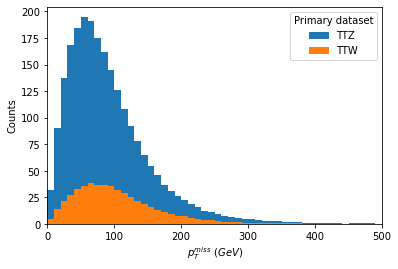

In [53]:
histogram = output['MET_pt'].copy()
histogram = histogram.rebin('pt', hist.Bin('pt', r'$p_T^{miss} \ (GeV)$', 50, 0, 500))

ax = hist.plot1d(histogram,overlay="dataset", stack=True)

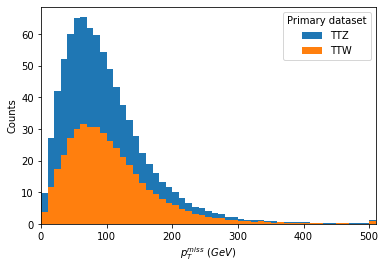

In [54]:
histogram = output['MET_pt_offZ'].copy()
histogram = histogram.rebin('pt', hist.Bin('pt', r'$p_T^{miss} \ (GeV)$', 50, 0, 500))

ax = hist.plot1d(histogram,overlay="dataset", stack=True, overflow='over')

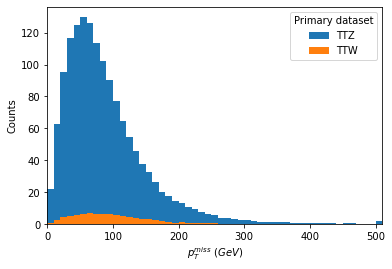

In [55]:
histogram = output['MET_pt_onZ'].copy()
histogram = histogram.rebin('pt', hist.Bin('pt', r'$p_T^{miss} \ (GeV)$', 50, 0, 500))

ax = hist.plot1d(histogram,overlay="dataset", stack=True, overflow='over')

We can also easily access the counts of the histogram...

In [56]:
histogram.values(overflow='over')

{('TTW',): array([0.71907501, 2.64613868, 4.1874841 , 5.18940433, 5.72005394,
        6.36463813, 6.85563426, 6.19916217, 6.34668523, 6.44966364,
        5.47998075, 4.93879333, 4.54294734, 3.54268812, 3.08382394,
        3.08476399, 2.51071635, 1.70910734, 1.52088748, 0.81266328,
        1.15686566, 0.85377325, 0.90666887, 0.57290205, 0.5104097 ,
        0.52135964, 0.23944719, 0.22912013, 0.12520168, 0.04121431,
        0.16662258, 0.21889532, 0.10443907, 0.10433474, 0.1042304 ,
        0.07313657, 0.0940056 , 0.03130042, 0.02086695, 0.05206303,
        0.06249651, 0.11424758, 0.03130042, 0.03140475, 0.01032914,
        0.03130042, 0.04152523, 0.07292998, 0.07303432, 0.02086695,
        0.15629344]),
 ('TTZ',): array([ 21.35158071,  60.26332079,  90.94740151, 111.44789052,
        118.875396  , 123.4789107 , 119.14953829, 107.31283827,
         96.07740583,  83.887999  ,  71.45463428,  59.6700992 ,
         49.83321825,  42.03539773,  34.42035359,  29.53687277,
         24.11339106, 

... also with the sum of the squared weights (that we need for the statistical uncertainties in the MC)

In [57]:
histogram.values(overflow='over', sumw2=True)

{('TTW',): (array([0.71907501, 2.64613868, 4.1874841 , 5.18940433, 5.72005394,
         6.36463813, 6.85563426, 6.19916217, 6.34668523, 6.44966364,
         5.47998075, 4.93879333, 4.54294734, 3.54268812, 3.08382394,
         3.08476399, 2.51071635, 1.70910734, 1.52088748, 0.81266328,
         1.15686566, 0.85377325, 0.90666887, 0.57290205, 0.5104097 ,
         0.52135964, 0.23944719, 0.22912013, 0.12520168, 0.04121431,
         0.16662258, 0.21889532, 0.10443907, 0.10433474, 0.1042304 ,
         0.07313657, 0.0940056 , 0.03130042, 0.02086695, 0.05206303,
         0.06249651, 0.11424758, 0.03130042, 0.03140475, 0.01032914,
         0.03130042, 0.04152523, 0.07292998, 0.07303432, 0.02086695,
         0.15629344]),
  array([0.01399061, 0.04384853, 0.0686012 , 0.08403495, 0.10300289,
         0.11258676, 0.12334193, 0.11974097, 0.11803383, 0.11347265,
         0.10489007, 0.0885895 , 0.07969352, 0.07036004, 0.05841164,
         0.05147288, 0.04393157, 0.03409673, 0.03147558, 0.02194803,
 

What's the ratio of ttW/ttZ events without the Z veto?

In [58]:
output['MET_pt']['TTW'].sum('dataset').values(overflow='over')[()].sum()/output['MET_pt']['TTZ'].sum('dataset').values(overflow='over')[()].sum()

0.28895678858410756

And now just off-Z

In [59]:
output['MET_pt_offZ']['TTW'].sum('dataset').values(overflow='over')[()].sum()/output['MET_pt_offZ']['TTZ'].sum('dataset').values(overflow='over')[()].sum()

1.0389757383664056

# Advanced topics

## DASK

We can use DASK to submit jobs to a cluster. This just serves as an example for now, I couldn't start a cluster this morning...

In principle, a cluster can be started by running `ipython -i start_cluster.py`


In [65]:
from Tools.helpers import get_scheduler_address

from dask.distributed import Client, progress

scheduler_address = get_scheduler_address()

c = Client(scheduler_address)

c

Client Scheduler: tcp://169.228.130.5:24687 Dashboard: http://169.228.130.5:13349/status,Cluster Workers: 34 Cores: 34 Memory: 102.00 GB


In [ ]:
exe_args = {
    'client': c,
}
exe = processor.dask_executor

output = processor.run_uproot_job(fileset,
                                      treename='Events',
                                      processor_instance=exampleProcessor(),
                                      executor=exe,
                                      executor_args=exe_args,
                                      chunksize=500000,
                                     )


[################################        ] | 80% Completed | 14min 16.4s

## Matching

Matching can be interesting for efficiency studies, overlap removal of different collections etc. Let's first do some gen matching.


In [ ]:
# The loaded samples contain a branch that is called GenL (generated leptons). This is non-standard for nanoAOD.

gen_lep = JaggedCandidateArray.candidatesfromcounts(
    df['nGenL'],
    pt = df['GenL_pt'].content,
    eta = df['GenL_eta'].content,
    phi = df['GenL_phi'].content,
    mass = ((df['GenL_pt']>0)*0).content,
    pdgId =  df['GenL_pdgId'].content,
)

In [ ]:
gen_lep = gen_lep[baseline]
gen_muon = gen_lep[abs(gen_lep.pdgId)==13]

In [ ]:
matched_gen_muon = gen_muon[gen_muon.match(muon, deltaRCut=0.4)]
unmatched_gen_muon = gen_muon[~gen_muon.match(muon, deltaRCut=0.4)]

In [ ]:
(matched_gen_muon.pt>20).flatten().sum()/(gen_muon.pt>20).flatten().sum()

In [ ]:
(unmatched_gen_muon.pt>20).flatten().sum()/(gen_muon.pt>20).flatten().sum()

Now let's do some cross cleaning, namely remove jets that overlap with leptons. First, let's load jets similarly to electrons and muons, and define some baseline requirements.

In [ ]:
jet = JaggedCandidateArray.candidatesfromcounts(
    df['nJet'],
    pt = df['Jet_pt'].content,
    eta = df['Jet_eta'].content,
    phi = df['Jet_phi'].content,
    mass = df['Jet_mass'].content,
    jetId = df['Jet_jetId'].content,
    puId = df['Jet_puId'].content,
    btagDeepB = df['Jet_btagDeepB'].content,
    
)
jet = jet[(jet.pt>30) & (abs(jet.eta)<2.4) & (jet.jetId>0)]
jet = jet[baseline]

In [ ]:
jet = jet[~jet.match(muon, deltaRCut=0.4)]
jet = jet[~jet.match(electron, deltaRCut=0.4)]